In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') 

#read csv with data
df = pd.read_csv('twitterdane.csv', engine='python', sep=',', quotechar='"', error_bad_lines=False)
df1 = pd.read_csv('kryptodane.csv', sep = r',', skipinitialspace = True, engine='python')

display(df, df1)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\szymo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,created_at,text
0,1.470000e+18,2021-11-30 13:20:58+00:00,"Look, If you had one shot, or one opportunity,..."
1,1.470000e+18,2021-11-29 13:03:58+00:00,"MicroStrategy has purchased an additional 7,00..."
2,1.470000e+18,2021-11-29 12:48:56+00:00,The #Bitcoin Also Rises
3,1.470000e+18,2021-11-29 01:12:25+00:00,#Bitcoin never sleeps.
4,1.460000e+18,2021-11-28 14:07:17+00:00,The future doesn't belong to the fainthearted....
...,...,...,...
266,1.430000e+18,2021-08-13 17:24:18+00:00,Bitcoin is such a fantastic hedge for all of t...
267,1.430000e+18,2021-08-12 11:24:18+00:00,Crypto fashion: why people pay real money for ...
268,1.420000e+18,2021-08-07 22:43:15+00:00,U.S.-based crypto companies will generate ~$10...
269,1.420000e+18,2021-08-04 12:37:56+00:00,Grayscale Hires ETF Head in Push to Convert Bi...


,ď»żDate,Open,High,Low,Close,Volume
0,1 January 2021,28963.116282,29674.366390,28692.320100,29402.176951,5.206879e+09
1,2 January 2021,29394.914671,33268.527789,29022.584583,32200.200909,1.150113e+10
2,3 January 2021,32209.643507,34810.548275,31984.603073,33061.908711,1.151527e+10
3,4 January 2021,32979.561700,33686.591916,27902.210046,32013.657608,1.317324e+10
4,5 January 2021,31983.572856,34495.109124,29915.527058,34033.028441,1.084223e+10
...,...,...,...,...,...,...
330,27 November 2021,53658.720932,55324.867900,53650.087750,54773.006786,3.729476e+09
331,28 November 2021,54788.864981,57487.247316,53288.543886,57324.801527,4.393759e+09
332,29 November 2021,57263.997918,58914.172865,56730.796175,57835.290333,5.250525e+09
333,30 November 2021,57828.516758,59236.909291,55921.668297,56980.612066,6.709355e+09


## Data preparations


In [3]:
#adding an row_id field to the dataframe, which will be useful for joining later
df["row_id"] = df.index + 1

#create a new data frame with "id" and "text" fields
df_subset = df[['row_id', 'text']].copy()

#data clean-up
#remove all non-aphabet characters
df_subset['text'] = df_subset['text'].str.replace("[^a-zA-Z#]", " ")

#covert to lower-case
df_subset['text'] = df_subset['text'].str.casefold()


display(df)
display(df_subset.head(10))

,id,created_at,text,row_id
0,1.470000e+18,2021-11-30 13:20:58+00:00,"Look, If you had one shot, or one opportunity,...",1
1,1.470000e+18,2021-11-29 13:03:58+00:00,"MicroStrategy has purchased an additional 7,00...",2
2,1.470000e+18,2021-11-29 12:48:56+00:00,The #Bitcoin Also Rises,3
3,1.470000e+18,2021-11-29 01:12:25+00:00,#Bitcoin never sleeps.,4
4,1.460000e+18,2021-11-28 14:07:17+00:00,The future doesn't belong to the fainthearted....,5
...,...,...,...,...
266,1.430000e+18,2021-08-13 17:24:18+00:00,Bitcoin is such a fantastic hedge for all of t...,267
267,1.430000e+18,2021-08-12 11:24:18+00:00,Crypto fashion: why people pay real money for ...,268
268,1.420000e+18,2021-08-07 22:43:15+00:00,U.S.-based crypto companies will generate ~$10...,269
269,1.420000e+18,2021-08-04 12:37:56+00:00,Grayscale Hires ETF Head in Push to Convert Bi...,270


,row_id,text
0,1,look if you had one shot or one opportunity ...
1,2,microstrategy has purchased an additional ...
2,3,the #bitcoin also rises
3,4,#bitcoin never sleeps
4,5,the future doesn t belong to the fainthearted ...
5,6,public service announcement every hour my tea...
6,7,everyone has double digit inflation if they me...
7,8,regardless of whether you are a pessimist or o...
8,9,#bitcoin offers better inflation protection th...
9,10,the trick is when there is nothing to do do ...


In [4]:
#set up empty dataframe for staging output
df2=pd.DataFrame()
df2['row_id']=['99999999999']
df2['sentiment_type']='NA999NA'
df2['sentiment_score']=0

## Sentiment analysis

In [5]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df2
for index, row in df_subset.iterrows():
    scores = sid.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        df2['row_id']=row[0]
        df2['sentiment_type']=key
        df2['sentiment_score']=value
        t_df=t_df.append(df2)

#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']

#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()

#only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']

print(t_df_cleaned.head(10))


Processing sentiment analysis...
   row_id sentiment_type  sentiment_score
0       1       compound           0.4215
0       2       compound           0.0000
0       3       compound           0.0000
0       4       compound           0.0000
0       5       compound          -0.0772
0       6       compound           0.8658
0       7       compound           0.0000
0       8       compound           0.2263
0       9       compound           0.5574
0      10       compound          -0.0516


C:\Users\szymo\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [7]:
#merge dataframes
df_output = pd.merge(df, t_df_cleaned, on='row_id', how='inner')
print(df_output.head(10))

             id                 created_at  \
0  1.470000e+18  2021-11-30 13:20:58+00:00   
1  1.470000e+18  2021-11-29 13:03:58+00:00   
2  1.470000e+18  2021-11-29 12:48:56+00:00   
3  1.470000e+18  2021-11-29 01:12:25+00:00   
4  1.460000e+18  2021-11-28 14:07:17+00:00   
5  1.460000e+18  2021-11-28 01:03:51+00:00   
6  1.460000e+18  2021-11-27 17:31:37+00:00   
7  1.460000e+18  2021-11-27 14:04:28+00:00   
8  1.460000e+18  2021-11-26 19:27:24+00:00   
9  1.460000e+18  2021-11-26 14:10:45+00:00   

                                                text  row_id sentiment_type  \
0  Look, If you had one shot, or one opportunity,...       1       compound   
1  MicroStrategy has purchased an additional 7,00...       2       compound   
2                            The #Bitcoin Also Rises       3       compound   
3                             #Bitcoin never sleeps.       4       compound   
4  The future doesn't belong to the fainthearted....       5       compound   
5  Public Service A

In [8]:
#basic statistic metrics for our output dataframe
df_output[["sentiment_score"]].describe()


,sentiment_score
count,271.000000
mean,0.167073
std,0.368643
min,-0.807400
25%,0.000000
50%,0.000000
75%,0.458800
max,0.920100


## Visualize data

Text(0.5, 0, 'Date 01.01 to 01.12.21')

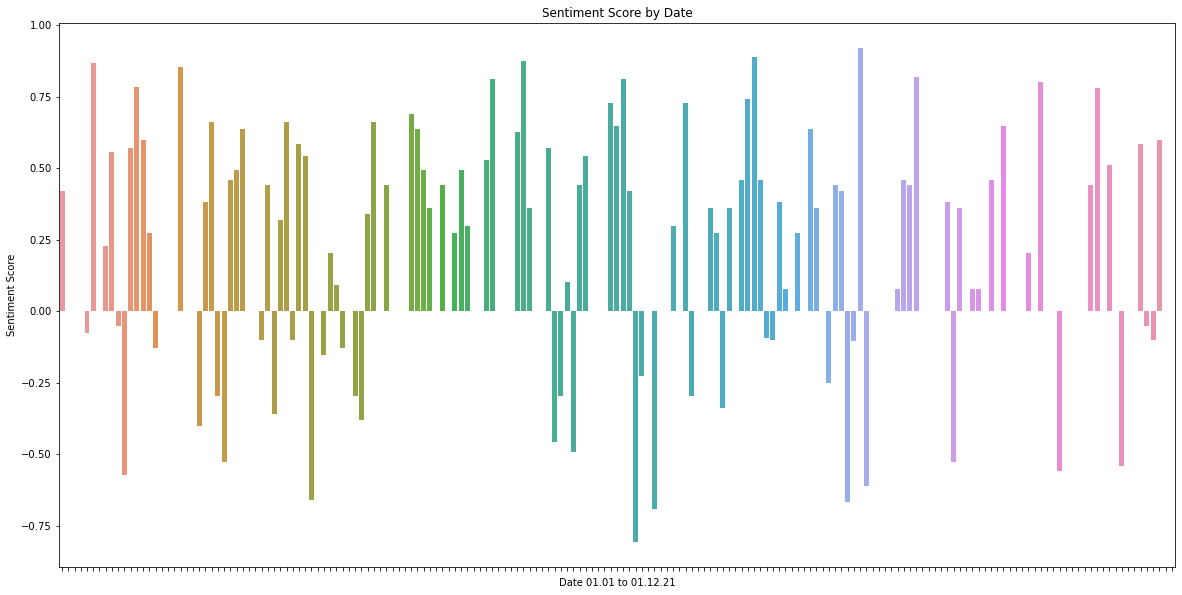

In [33]:
import numpy as np 
import seaborn as sns

#set up figsize to be more visible
plt.figure(figsize=(20,10))

#create seaborn boxplots by group
sns.barplot(x='created_at', y='sentiment_score',
            data=df_output).set(title='Sentiment Score by Date')

#modify axis labels
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.xlabel("Date 01.01 to 01.12.21")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ď»żDate   335 non-null    object 
 1   Open      335 non-null    float64
 2   High      335 non-null    float64
 3   Low       335 non-null    float64
 4   Close     335 non-null    float64
 5   Volume    332 non-null    float64
 6   day_mean  335 non-null    float64
dtypes: float64(6), object(1)
memory usage: 18.4+ KB
['ď»żDate', 'Open', 'High', 'Low', 'Close', 'Volume', 'day_mean']


,ď»żDate,Open,High,Low,Close,Volume,day_mean
0,1 January 2021,28963.116282,29674.366390,28692.320100,29402.176951,5.206879e+09,29183.343245
1,2 January 2021,29394.914671,33268.527789,29022.584583,32200.200909,1.150113e+10,31145.556186
2,3 January 2021,32209.643507,34810.548275,31984.603073,33061.908711,1.151527e+10,33397.575674
3,4 January 2021,32979.561700,33686.591916,27902.210046,32013.657608,1.317324e+10,30794.400981
4,5 January 2021,31983.572856,34495.109124,29915.527058,34033.028441,1.084223e+10,32205.318091
...,...,...,...,...,...,...,...
330,27 November 2021,53658.720932,55324.867900,53650.087750,54773.006786,3.729476e+09,54487.477825
331,28 November 2021,54788.864981,57487.247316,53288.543886,57324.801527,4.393759e+09,55387.895601
332,29 November 2021,57263.997918,58914.172865,56730.796175,57835.290333,5.250525e+09,57822.484520
333,30 November 2021,57828.516758,59236.909291,55921.668297,56980.612066,6.709355e+09,57579.288794


[]

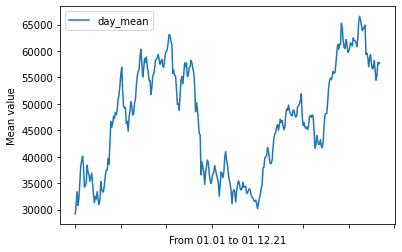

In [27]:
#getting dataframe informations
df1.info()
df1.dtypes
print(df1.columns.tolist())

#preparing dataframe to be plot, adding new column day_mean
df1['High'].astype('float')
df1['Low'].astype('float')
col = df1.loc[: , 'High':'Low']
df1['day_mean'] = col.mean(axis=1)

#plotting dataframe
df1.plot(x='ď»żDate', y='day_mean', kind='line')

plt.ylabel('Mean value')
plt.xlabel("From 01.01 to 01.12.21")
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])


## Correlation

In [106]:
#getting and priting correaltion between sentiment and mean value
print(df_output.corrwith(df1['day_mean']))
display(df_output['sentiment_score'])
display(df1['day_mean'])


id                 0.204955
row_id            -0.083187
sentiment_score    0.004232
dtype: float64


0      0.4215
1      0.0000
2      0.0000
3      0.0000
4     -0.0772
        ...  
266   -0.0516
267   -0.1027
268    0.5994
269    0.0000
270    0.0000
Name: sentiment_score, Length: 271, dtype: float64

0      29183.343245
1      31145.556186
2      33397.575674
3      30794.400981
4      32205.318091
           ...     
330    54487.477825
331    55387.895601
332    57822.484520
333    57579.288794
334    57793.508168
Name: day_mean, Length: 335, dtype: float64